In [2]:
import torch
from torch import nn, optim, Tensor
from datasets import load_dataset, load_dataset_builder
from torch.utils.data import DataLoader, default_collate, Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import torchvision
import imageio
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from collections.abc import Mapping
from PIL import Image
import PIL

# Data : https://www.kaggle.com/datasets/kumaresanmanickavelu/lyft-udacity-challenge

In [3]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {def_device}')

# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

Using device: cuda


In [4]:
DATA_DIR = "dataA"

images_dir = DATA_DIR + "/CameraRGB"
masks_dir = DATA_DIR + "/CameraSeg"

num_classes = 13

In [5]:
image_paths = os.listdir(images_dir)
image_paths = [os.path.join(images_dir, path) for path in image_paths]
mask_paths = os.listdir(masks_dir)
mask_paths = [os.path.join(masks_dir, path) for path in mask_paths]

print(f"Number of images: {len(image_paths)}")

Number of images: 1000


Image shape: (600, 800, 3)
Mask shape: (600, 800, 3)
Image shape: (600, 800, 3)
Mask shape: (600, 800)


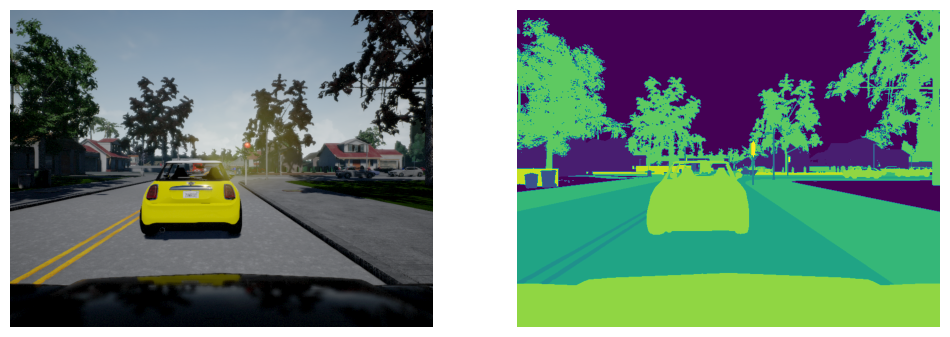

In [6]:
image = plt.imread(image_paths[1])
mask = plt.imread(mask_paths[1])

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(image.shape[0], image.shape[1])

print(f"Image shape: {image.shape}")
print(f"Mask shape: {mask.shape}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.show()


In [7]:
# Shuffle the images and masks

rng_state = np.random.get_state()
np.random.shuffle(image_paths)
np.random.set_state(rng_state)
np.random.shuffle(mask_paths)

In [8]:
train_spilt = 0.8

train_images = image_paths[:int(len(image_paths)*train_spilt)]
train_masks = mask_paths[:int(len(image_paths)*train_spilt)]

test_images= image_paths[int(len(image_paths)*train_spilt):]
test_masks= mask_paths[int(len(image_paths)*train_spilt):]

In [9]:
class myDataset(Dataset):
    def __init__(self, image_paths, mask_paths,sz = (256,256), transforms=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.sz = sz
        self.transforms = transforms
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, i):
        image = Image.open(self.image_paths[i])
        image = image.resize(self.sz , resample=PIL.Image.NEAREST)
        mask = Image.open(self.mask_paths[i])
        mask = mask.resize(self.sz , resample=PIL.Image.NEAREST)
        if self.transforms: 
            image = self.transforms(image)
            mask = self.transforms(mask)
        return image, mask[0]*255

In [10]:
transforms = T.Compose([T.ToTensor()])

train_ds = myDataset(image_paths=train_images, mask_paths=train_masks, transforms=transforms)
valid_ds = myDataset(image_paths=test_images, mask_paths=test_masks, transforms=transforms)

In [47]:
BATCH_SIZE = 4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)

torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


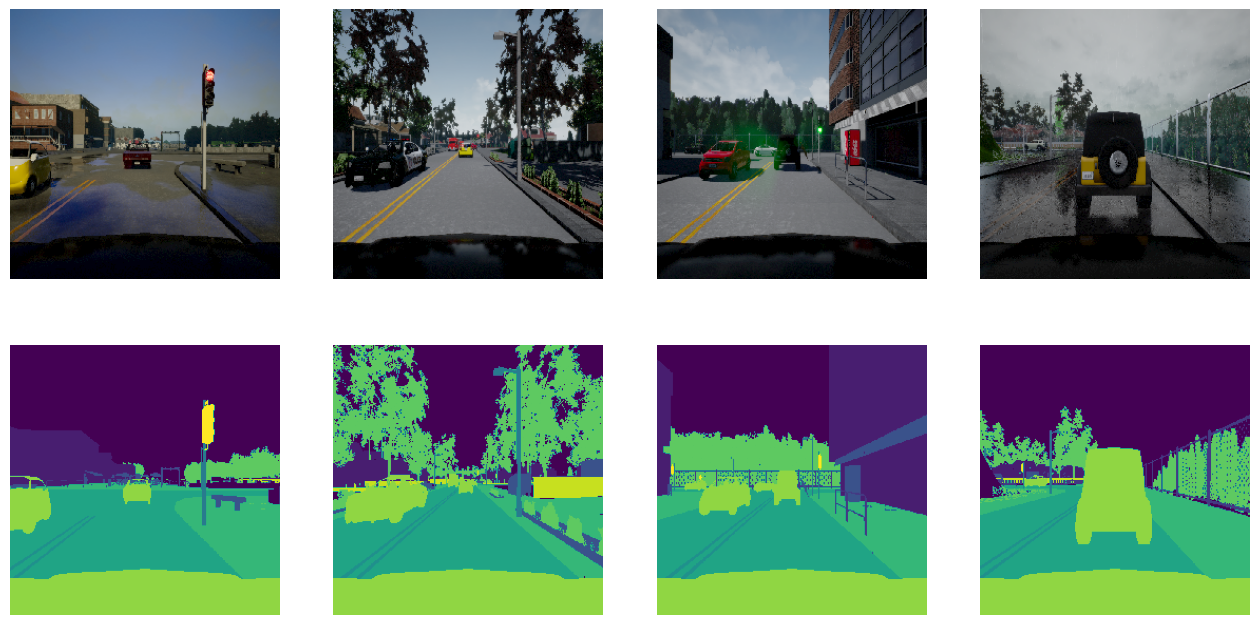

In [12]:
batch = next(iter(train_dl))
images, masks = batch

print(images.shape, masks.shape)

plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i])
    plt.axis('off')
plt.show()

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        factor = 2 if bilinear else 1
        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x4, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [15]:
model = UNet(3, num_classes)
model = model.to(def_device)

In [16]:
batch = next(iter(train_dl))
images, labels = batch
preds = model(images.to(def_device))
print(preds.shape)

torch.Size([4, 13, 256, 256])


In [17]:
lr = 1e-2
epochs = 15
opt = optim.Adam(model.parameters(), lr=lr, eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt, lr, epochs=epochs, steps_per_epoch=len(train_dl))
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

In [18]:
def fit(model, epochs, opt, sched, criterion, train_dl, valid_dl):
    for epoch in range(epochs):
        tot_loss,tot_acc,count = 0.,0.,0
        model.train()
        for images, labels in tqdm(train_dl, total=len(train_dl)):
            opt.zero_grad()
            labels = labels.squeeze(1)
            images = images.to(def_device)
            labels = labels.to(def_device)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                preds = model(images)
                loss = criterion(preds, labels.long())
            n = len(images)
            count += n
            tot_loss += loss.item()*n
            tot_acc  += (preds.argmax(dim=1)==labels).float().mean().item()*n
            scaler.scale(loss).backward()
            scaler.step(opt)
            sched.step()
            scaler.update()
        print(f"Epoch {epoch} - Training Loss: {tot_loss/count} - Training Accuracy: {tot_acc/count}")
        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for images, labels in tqdm(valid_dl, total=len(valid_dl)):
                labels = labels.squeeze(1)
                images = images.to(def_device)
                labels = labels.to(def_device)
                preds = model(images)
                n = len(images)
                count += n
                tot_loss += criterion(preds,labels.long()).item()*n
                tot_acc  += (preds.argmax(dim=1)==labels).float().mean().item()*n
        print(f"Epoch {epoch} - Validation Loss: {tot_loss/count} - Validation Accuracy: {tot_acc/count}")

In [19]:
# fit(model, epochs, opt, sched, criterion, train_dl, valid_dl)

100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


Epoch 0 - Training Loss: 0.9399251556396484 - Training Accuracy: 0.7482060050964355


100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


Epoch 0 - Validation Loss: 0.6786277467012405 - Validation Accuracy: 0.8066561889648437


100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Epoch 1 - Training Loss: 0.5431967620551587 - Training Accuracy: 0.8376526260375976


100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


Epoch 1 - Validation Loss: 0.8344194006919861 - Validation Accuracy: 0.7306316375732422


100%|██████████| 200/200 [00:40<00:00,  4.98it/s]


Epoch 2 - Training Loss: 0.4685863424837589 - Training Accuracy: 0.8589518165588379


100%|██████████| 50/50 [00:05<00:00,  9.35it/s]


Epoch 2 - Validation Loss: 0.959317786693573 - Validation Accuracy: 0.7054496765136719


100%|██████████| 200/200 [00:41<00:00,  4.80it/s]


Epoch 3 - Training Loss: 0.42465137094259264 - Training Accuracy: 0.8711733245849609


100%|██████████| 50/50 [00:05<00:00,  8.42it/s]


Epoch 3 - Validation Loss: 0.40576492428779604 - Validation Accuracy: 0.881478042602539


100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


Epoch 4 - Training Loss: 0.3605410975962877 - Training Accuracy: 0.8900613021850586


100%|██████████| 50/50 [00:06<00:00,  7.85it/s]


Epoch 4 - Validation Loss: 0.5667857134342194 - Validation Accuracy: 0.8113504028320313


100%|██████████| 200/200 [00:46<00:00,  4.32it/s]


Epoch 5 - Training Loss: 0.2981733337044716 - Training Accuracy: 0.9083612060546875


100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 5 - Validation Loss: 0.5968617647886276 - Validation Accuracy: 0.8415731048583984


100%|██████████| 200/200 [00:47<00:00,  4.23it/s]


Epoch 6 - Training Loss: 0.2452316728979349 - Training Accuracy: 0.9240721893310547


100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Epoch 6 - Validation Loss: 0.2402742499113083 - Validation Accuracy: 0.925305404663086


100%|██████████| 200/200 [00:46<00:00,  4.27it/s]


Epoch 7 - Training Loss: 0.22204315751791 - Training Accuracy: 0.9308239364624024


100%|██████████| 50/50 [00:05<00:00,  8.40it/s]


Epoch 7 - Validation Loss: 0.25146945983171465 - Validation Accuracy: 0.92447021484375


100%|██████████| 200/200 [00:43<00:00,  4.64it/s]


Epoch 8 - Training Loss: 0.18840291887521743 - Training Accuracy: 0.9411070823669434


100%|██████████| 50/50 [00:05<00:00,  8.66it/s]


Epoch 8 - Validation Loss: 0.18955698788166045 - Validation Accuracy: 0.9408688354492187


100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


Epoch 9 - Training Loss: 0.1662335802614689 - Training Accuracy: 0.9477238655090332


100%|██████████| 50/50 [00:05<00:00,  8.74it/s]


Epoch 9 - Validation Loss: 0.1635133908689022 - Validation Accuracy: 0.9491175079345703


100%|██████████| 200/200 [00:39<00:00,  5.05it/s]


Epoch 10 - Training Loss: 0.14798704359680415 - Training Accuracy: 0.9531836318969726


100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


Epoch 10 - Validation Loss: 0.14538519144058226 - Validation Accuracy: 0.9546350860595703


100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


Epoch 11 - Training Loss: 0.1327725923806429 - Training Accuracy: 0.9576952171325683


100%|██████████| 50/50 [00:05<00:00,  9.52it/s]


Epoch 11 - Validation Loss: 0.13353000521659852 - Validation Accuracy: 0.957805404663086


100%|██████████| 200/200 [00:40<00:00,  4.93it/s]


Epoch 12 - Training Loss: 0.11888372987508773 - Training Accuracy: 0.9618308448791504


100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


Epoch 12 - Validation Loss: 0.125311918258667 - Validation Accuracy: 0.9605204772949218


100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


Epoch 13 - Training Loss: 0.11201381258666515 - Training Accuracy: 0.9639740753173828


100%|██████████| 50/50 [00:05<00:00,  8.95it/s]


Epoch 13 - Validation Loss: 0.12129291176795959 - Validation Accuracy: 0.9616232299804688


100%|██████████| 200/200 [00:40<00:00,  4.97it/s]


Epoch 14 - Training Loss: 0.10815975964069366 - Training Accuracy: 0.9651203918457031


100%|██████████| 50/50 [00:05<00:00,  9.12it/s]

Epoch 14 - Validation Loss: 0.1212726166844368 - Validation Accuracy: 0.9616687774658204


In [ ]:
# torch.save(model.state_dict(), "segmentation.pth")

In [ ]:
model = UNet(3, num_classes)
model.load_state_dict(torch.load("segmentation.pth"))
model = model.to(def_device)

Images:


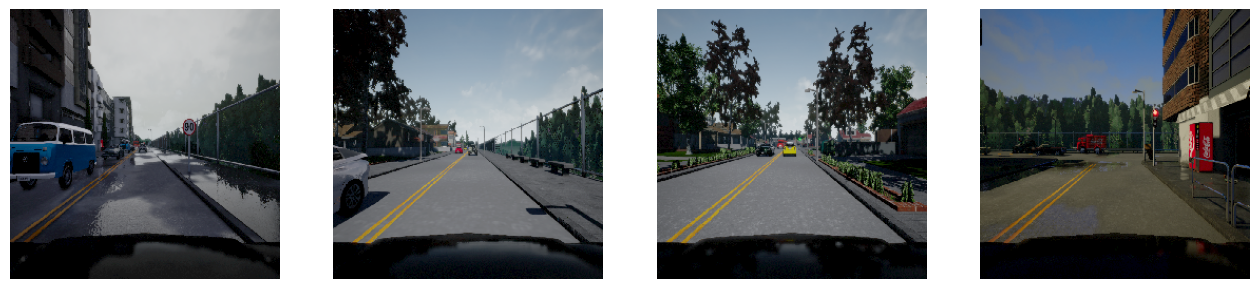

True masks:


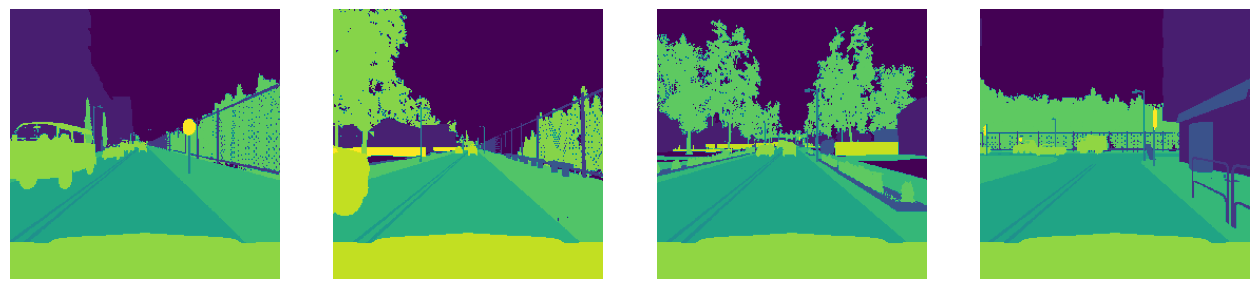

Predicted masks:


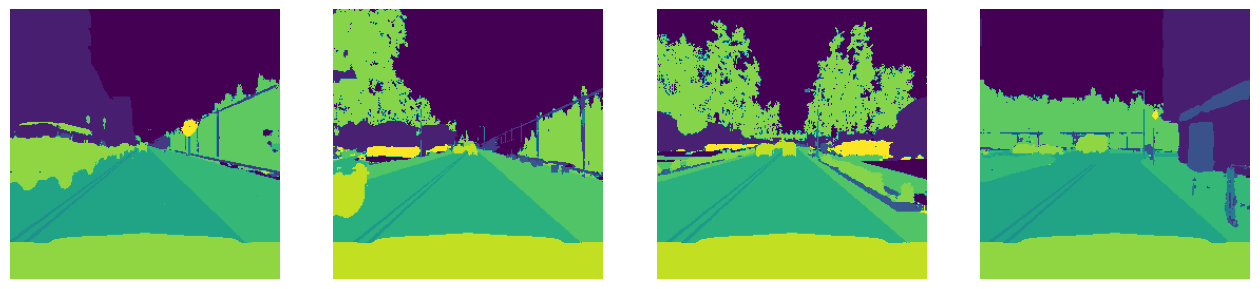

In [48]:
batch = next(iter(valid_dl))
images, labels = batch
preds = model(images.to(def_device))

print("Images:")
plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
plt.show()
print("True masks:")
plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(labels[i])
    plt.axis('off')
plt.show()
print("Predicted masks:")
plt.figure(figsize=(16, 8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(preds[i].argmax(dim = 0).cpu())
    plt.axis('off')
plt.show()